<a href="https://colab.research.google.com/github/JoySoon/MachineLearning/blob/backup/JoySoon/ch08_ML_07_XGBoost_KSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment
# https://github.com/BigData23th/Data/raw/main/dating.csv
df = pd.read_csv("https://github.com/BigData23th/Data/raw/main/dating.csv")
df

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
0,0,female,21.0,27.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,35.0,20.0,...,7.0,6.0,5.0,0.14,3.0,2.0,7.0,6.0,0.0,0
1,0,female,21.0,22.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,60.0,0.0,...,8.0,5.0,6.0,0.54,3.0,2.0,7.0,5.0,1.0,0
2,1,female,21.0,22.0,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.0,4.0,19.0,18.0,...,8.0,5.0,7.0,0.16,3.0,2.0,7.0,NaN,1.0,1
3,0,female,21.0,23.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,30.0,5.0,...,7.0,6.0,8.0,0.61,3.0,2.0,7.0,6.0,0.0,1
4,0,female,21.0,24.0,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.0,4.0,30.0,10.0,...,7.0,6.0,6.0,0.21,3.0,2.0,6.0,6.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,1,male,25.0,26.0,European/Caucasian-American,Latino/HispanicAmerican,1.0,1.0,10.0,10.0,...,5.0,NaN,NaN,0.64,10.0,NaN,2.0,5.0,0.0,0
8374,1,male,25.0,24.0,European/Caucasian-American,Other,1.0,1.0,50.0,20.0,...,4.0,4.0,NaN,0.71,10.0,NaN,4.0,4.0,0.0,0
8375,1,male,25.0,29.0,European/Caucasian-American,Latino/HispanicAmerican,1.0,1.0,40.0,10.0,...,8.0,8.0,NaN,-0.46,10.0,NaN,6.0,5.0,0.0,0
8376,1,male,25.0,22.0,European/Caucasian-American,Asian/PacificIslander/Asian-American,1.0,1.0,10.0,25.0,...,4.0,NaN,5.0,0.62,10.0,NaN,5.0,5.0,0.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8378 non-null   int64  
 1   gender                         8378 non-null   object 
 2   age                            8283 non-null   float64
 3   age_o                          8274 non-null   float64
 4   race                           8315 non-null   object 
 5   race_o                         8305 non-null   object 
 6   importance_same_race           8299 non-null   float64
 7   importance_same_religion       8299 non-null   float64
 8   pref_o_attractive              8289 non-null   float64
 9   pref_o_sincere                 8289 non-null   float64
 10  pref_o_intelligence            8289 non-null   float64
 11  pref_o_funny                   8280 non-null   float64
 12  pref_o_ambitious               8271 non-null   f

# 변수 목록

## 목표값, 종속변수, 라벨, y
* match : 커플 성사 여부

## 관측값, 독립변수, 피처, X
* has_null
    - 변수 중 Null값이 있는지 여부. 단, 이 데이터는 기존 데이터에서 일부 변수들이 생략된 축소판이기 때문에, 여기서 보이는 Null값 여부와 다소 차이가 있을 수 있음.
    - 전반적으로 무응답 항목이 있는지에 대한 정보이므로 그대로 사용
* age / age_o : age는 본인 나이이며 age_o는 상대방 나이.
* race / race_o : 마찬가지로 본인과 상대의 인종 정보.
* importance_same_race / importance_same_religion
    * 인종과 종교를 중요시 여기는지에 대한 응답
* attractive(매력적인), sincere(성실한), intelligence(지적), funny(재미난), ambitious(야심찬), shared_ interests(공통관심사) : 이 항목들은 4가지 관점에서 평가되어 총 변수가 24(6 × 4)개
    * pref_o_xxx( 예 : pref_o_attractive) : 상대방이 xxx 항목을 얼마나 중요하게 생각하는가에 대한 응답
    * xxx_o(예: attractive_o) : 상대방이 본인에 대한 xxx 항목을 평가한 항목
    * xxx_important(예 : attractive_important) : xxx 항목에 대해 본인이 얼마나 중요하게 생각하는가에 대한 응답
    * xxx_partner(예 : attractive_partner) : 본인이 상대방에 대한 xxx 항목을 평가한 항목
* interests_correlate : 관심사(취미 등) 연관도
* expected_happy_with_sd_people : 스피드 데이팅을 통해 만난 사람과 함께할 때 얼마나 좋을
지에 대한 기대치
* expected_num_interested_in_me : 얼마나 많은 사람이 나에게 관심을 보일지에 대한 기대치
* like : 파트너가 마음에 들었는지 여부
* guess_prob_liked : 파트너가 나를 마음에 들어했을지에 대한 예상
* met: 파트너를 스피드 데이팅 이벤트 이전에 만난 적이 있는지 여부

In [4]:
pd.options.display.float_format = "{:.2f}".format
df.describe() # 연속형 변수

,has_null,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
count,8378.00,8283.00,8274.00,8299.00,8299.00,8289.00,8289.00,8289.00,8280.00,8271.00,...,8028.00,7666.00,7311.00,8220.00,8277.00,1800.00,8138.00,8069.00,8003.00,8378.00
mean,0.87,26.36,26.36,3.78,3.65,22.50,17.40,20.27,17.46,10.69,...,6.40,6.78,5.47,0.20,5.53,5.57,6.13,5.21,0.05,0.16
std,0.33,3.57,3.56,2.85,2.81,12.57,7.04,6.78,6.09,6.13,...,1.95,1.79,2.16,0.30,1.73,4.76,1.84,2.13,0.28,0.37
min,0.00,18.00,18.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.83,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,24.00,24.00,1.00,1.00,15.00,15.00,17.39,15.00,5.00,...,5.00,6.00,4.00,-0.02,5.00,2.00,5.00,4.00,0.00,0.00
50%,1.00,26.00,26.00,3.00,3.00,20.00,18.37,20.00,18.00,10.00,...,7.00,7.00,6.00,0.21,6.00,4.00,6.00,5.00,0.00,0.00
75%,1.00,28.00,28.00,6.00,6.00,25.00,20.00,23.81,20.00,15.00,...,8.00,8.00,7.00,0.43,7.00,8.00,7.00,7.00,0.00,0.00
max,1.00,55.00,55.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,...,10.00,10.00,10.00,0.91,10.00,20.00,10.00,10.00,8.00,1.00


In [5]:
df.describe(include='O')

,gender,race,race_o
count,8378,8315,8305
unique,2,5,5
top,male,European/Caucasian-American,European/Caucasian-American
freq,4194,4727,4722


# 전처리

## 결측치

In [6]:
df.isna().mean()
# 오름차순 (행방향=데이터 커지는 방향)
df.isna().mean().sort_values()
# 내림차순 (행방향=데이터 작아지는 방향)
df.isna().mean().sort_values(ascending=False)

expected_num_interested_in_me   0.79
shared_interests_o              0.13
shared_interests_partner        0.13
ambitous_o                      0.09
ambition_partner                0.08
met                             0.04
funny_o                         0.04
funny_partner                   0.04
guess_prob_liked                0.04
intelligence_o                  0.04
intelligence_partner            0.04
sincere_o                       0.03
sincere_partner                 0.03
like                            0.03
attractive_o                    0.03
attractive_partner              0.02
interests_correlate             0.02
pref_o_shared_interests         0.02
shared_interests_important      0.01
pref_o_ambitious                0.01
age_o                           0.01
expected_happy_with_sd_people   0.01
ambtition_important             0.01
pref_o_funny                    0.01
age                             0.01
pref_o_sincere                  0.01
pref_o_attractive               0.01
f

In [7]:
# na를 다 drop하는 게 아니라, 특정한 열 결측치가 있을 경우만 행을 삭제
# subset = [결측치가 있다면 행을 삭제할 열들 이름]
# 일부 변수에서 결측치 제거
# df.dropna -> 전체 결측치 제거
# subset -> 특정 열이 결측치일 경우에 제거
df = df.dropna(
    subset = [
        'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
        'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests',
        'attractive_important', 'sincere_important', 'intellicence_important',
        'funny_important', 'ambtition_important', 'shared_interests_important']
)

In [8]:
df.isna().mean().sort_values(ascending=False)

expected_num_interested_in_me   0.79
shared_interests_o              0.13
shared_interests_partner        0.13
ambitous_o                      0.08
ambition_partner                0.08
met                             0.04
funny_o                         0.04
funny_partner                   0.04
guess_prob_liked                0.04
intelligence_o                  0.03
intelligence_partner            0.03
sincere_o                       0.03
sincere_partner                 0.03
like                            0.03
attractive_partner              0.02
attractive_o                    0.02
age_o                           0.00
age                             0.00
expected_happy_with_sd_people   0.00
funny_important                 0.00
interests_correlate             0.00
shared_interests_important      0.00
ambtition_important             0.00
has_null                        0.00
intellicence_important          0.00
sincere_important               0.00
attractive_important            0.00
g

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 0 to 8377
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8130 non-null   int64  
 1   gender                         8130 non-null   object 
 2   age                            8108 non-null   float64
 3   age_o                          8108 non-null   float64
 4   race                           8130 non-null   object 
 5   race_o                         8130 non-null   object 
 6   importance_same_race           8130 non-null   float64
 7   importance_same_religion       8130 non-null   float64
 8   pref_o_attractive              8130 non-null   float64
 9   pref_o_sincere                 8130 non-null   float64
 10  pref_o_intelligence            8130 non-null   float64
 11  pref_o_funny                   8130 non-null   float64
 12  pref_o_ambitious               8130 non-null   f

In [10]:
# 결측치를 모두 -99로 채워주기
# df = df.fillna(-99)
df.fillna(-99, inplace=True)

<ipython-input-10-d163df6beab3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(-99, inplace=True)


In [11]:
# 결측치 처리 완료
df.isna().mean().sort_values(ascending=False)

has_null                        0.00
funny_partner                   0.00
intellicence_important          0.00
funny_important                 0.00
ambtition_important             0.00
shared_interests_important      0.00
attractive_partner              0.00
sincere_partner                 0.00
intelligence_partner            0.00
ambition_partner                0.00
attractive_important            0.00
shared_interests_partner        0.00
interests_correlate             0.00
expected_happy_with_sd_people   0.00
expected_num_interested_in_me   0.00
like                            0.00
guess_prob_liked                0.00
met                             0.00
sincere_important               0.00
shared_interests_o              0.00
gender                          0.00
pref_o_sincere                  0.00
age                             0.00
age_o                           0.00
race                            0.00
race_o                          0.00
importance_same_race            0.00
i

In [12]:
# 결측치만 채운 상태에서 XGBoost로 모델링 결과
# -> 피처 엔지니어링을 통해서 변수를 변형/추가 했을 경우에 결과
df['match'].mean() # 16.4% 성사 확률 (1)
1 - df['match'].mean() # 83.5% 서로 안맞을 확률 (0)
# -> 안맞는다고만 해도 83%

0.8351783517835178

## 피처 엔지니어링 없이 모델링

In [13]:
df2 = df.copy()

In [14]:
df2.describe(include='O').columns

Index(['gender', 'race', 'race_o'], dtype='object')

In [15]:
df2 = pd.get_dummies(df2, columns=df2.describe(include='O').columns)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 0 to 8377
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   has_null                                     8130 non-null   int64  
 1   age                                          8130 non-null   float64
 2   age_o                                        8130 non-null   float64
 3   importance_same_race                         8130 non-null   float64
 4   importance_same_religion                     8130 non-null   float64
 5   pref_o_attractive                            8130 non-null   float64
 6   pref_o_sincere                               8130 non-null   float64
 7   pref_o_intelligence                          8130 non-null   float64
 8   pref_o_funny                                 8130 non-null   float64
 9   pref_o_ambitious                             8130 non-null   float64
 10  

In [16]:
X = df2.drop('match', axis = 1) # 독립변수, 관측값
y = df2['match'] # 종속변수 ,목표값(예측값), 라벨

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=230
)

In [18]:
import xgboost as xgb # pip install

In [19]:
# xgb.XGBClassfier : 분류, 클래스, 이진
# xgb.XGBRegressor : 회귀, 연속형 변수
model = xgb.XGBClassifier(random_state=23)

In [20]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=23, ...)

In [21]:
pred = model.predict(X_test) # 시험셋으로 예측한 데이터
pred

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
pred_ = model.predict(X_train) # 학습셋으로 예측한 데이터
pred_

array([0, 1, 0, ..., 1, 0, 0])

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
accuracy_score(y_train, pred_)

0.9998462484624846

In [25]:
accuracy_score(y_test, pred)

0.8554735547355473

[[1273   54]
 [ 181  118]]


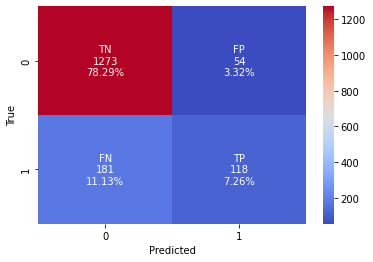

In [26]:
from sklearn.metrics import confusion_matrix

# 오른쪽 위 : 1종 오류 - 실제 틀린데 (0) 맞다고 예측 (1) - 68
# 왼쪽 아래 : 2종 오류 - 실제 맞는데 (1) 틀리다고 예측 (0) - 147
print(confusion_matrix(y_test, pred))
cf_matrix = confusion_matrix(y_test,pred)
cf_matrix
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()
# TP(양성을 양성으로 판단)
# FN(양성을 음성으로 판단) -> 2종 오류 (맞는데 틀리다고)
# FP(음성을 양성으로 판단) -> 1종 오류 (틀린데 맞다고)
# TN(음성을 음성으로 판단) 

## 피처 엔지니어링
* 피처 (Feature, 특징) : 독립변수
* 엔지니어링 : 가공을 해서 더 유의미하게 만들겠다
---
* Titanic -> Name => Title
* 단위 -> 통일

### age_gap

In [27]:
df.columns

Index(['has_null', 'gender', 'age', 'age_o', 'race', 'race_o',
       'importance_same_race', 'importance_same_religion', 'pref_o_attractive',
       'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
       'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o',
       'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o', 'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive_partner', 'sincere_partner',
       'intelligence_partner', 'funny_partner', 'ambition_partner',
       'shared_interests_partner', 'interests_correlate',
       'expected_happy_with_sd_people', 'expected_num_interested_in_me',
       'like', 'guess_prob_liked', 'met', 'match'],
      dtype='object')

In [28]:
# age : 본인의 나, age_o : 상대방의 나이
# df[df.age == -99]
(df.age == -99).mean() # True로 되어 있는 불리언 배열 -> mean() -> 해당 조건을 만족시키는 행들의 비중
(df.age_o == -99).mean() # True로 되어 있는 불리언 배열 -> mean() -> 해당 조건을 만족시키는 행들의 비중

0.002706027060270603

In [29]:
df.gender.unique() # male : 남성 / female : 여성

array(['female', 'male'], dtype=object)

In [30]:
# 1. 내 나이가 결측치일 경우 -> 결측치
# 2. 상대방의 나이가 결측치일 경우 -> 결측치
# 3. 상대방과 내 나이가 모두 있을 경우 (차이를 구할 수 있음)
# 3-1. (내가 남성) : 상대방과 나이 차이 -> 내 나이에서 상대방 나이를 빼고
# 3-2. (... 여성) : 상대방과 나이 차이 -> 상대방 나이에서 내 나이를 빼는 방식
# df.apply(..., axis=1) -> 특정 행의 전체 열
# df.age = 본인 나이, df.age_o = 상대방 나이
def age_gap(row): # row -> 데이터 프레임에서의 각 행 -> 속성(키 - 밸류) 값
    # 1. 내 나이가 결측치(-99)일 경우
    if row.age == -99: return -99 # return => 함수가 뒤를 더 이상 처리 X
    # 2. 상대방 나이가 ...
    if row.age_o == -99: return -99
    # 3-1. 남성일 경우 -> 내 나이 - 상대방 나이
    if row.gender == 'male': return row.age - row.age_o
    # 3-2. 여성일 경우 -> 상대방 나이 - 내 나이
    if row.gender == 'female': return row.age_o - row.age
    # 나머지 값은 X

In [31]:
# 행을 기준으로 모든 열을 사용해주려면...
# df.apply(age_gap, axis=1).unique()
df['age_gap'] = df.apply(age_gap, axis=1)

<ipython-input-31-39aef14509eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_gap'] = df.apply(age_gap, axis=1)


In [32]:
# 나이 차이 + 성별간의 차이
df['age_gap'].head()

0   6.00
1   1.00
2   1.00
3   2.00
4   3.00
Name: age_gap, dtype: float64

In [33]:
# abs : 절대값 -> 성별의 영향 없이 진짜 나이 차이만 보겠다
def age_gap_abs(row):
    # 1. 내 나이가 결측치(-99)일 경우
    if row.age == -99: return -99 # return => 함수가 뒤를 더 이상 처리 X
    # 2. 상대방 나이가 ...
    if row.age_o == -99: return -99
    # 3. 둘 사이의 차이를 abs() -> 절대값으로 나타내기
    return abs(row.age - row.age_o)

In [34]:
# 행을 기준으로 모든 열을 사용해주려면...
df['age_gap_abs'] = df.apply(age_gap_abs, axis=1)

<ipython-input-34-53e15a68cb1d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_gap_abs'] = df.apply(age_gap_abs, axis=1)


In [35]:
# 나이 + 성별
df['age_gap'].unique()

array([  6.,   1.,   2.,   3.,   4.,   9.,   7.,  -2.,  -1.,   0.,  -3.,
         5.,   8.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -12., -13., -10.,
        17.,  10.,  16.,  13.,  12.,  11.,  14., -14., -11.,  18.,  15.,
        19.,  20., -16., -15., -22., -28., -32., -99.])

In [36]:
# 나이
df['age_gap_abs'].unique()

array([  6.,   1.,   2.,   3.,   4.,   9.,   7.,   0.,   5.,   8.,  12.,
        13.,  10.,  17.,  16.,  11.,  14.,  18.,  15.,  19.,  20.,  22.,
        28.,  32., -99.])

### race

In [37]:
# 내 인종
df.race.value_counts()

European/Caucasian-American             4629
Asian/PacificIslander/Asian-American    1946
Latino/HispanicAmerican                  631
Other                                    513
Black/AfricanAmerican                    411
Name: race, dtype: int64

In [38]:
# 상대방 인종
df.race_o.value_counts()

European/Caucasian-American             4629
Asian/PacificIslander/Asian-American    1946
Latino/HispanicAmerican                  631
Other                                    513
Black/AfricanAmerican                    411
Name: race_o, dtype: int64

In [39]:
# 1. 인종이 일치하나?
# 2. 일치 여부에 따라서 중요도를 곱해서 점수화
# df.race : 내 인종
# df.race_o : 상대방 인종
# df.apply(..., axis=1) 특정 행의 모든 열의 데이터를 조회
def same_race(row):
    # 결측치 (-99)
    if row.race == -99 or row.race_o == -99: return -99
    if row.race == row.race_o: return 1
    return -1
    # 삼항연산자
    # {조건을 만족시켰을 때의 결과값} if {조건} else {만족X 결과값}
    # return 1 if row.race == row.race_o else -1

In [40]:
df['same_race'] = df.apply(same_race, axis=1)

<ipython-input-40-14bcb61b2ee3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['same_race'] = df.apply(same_race, axis=1)


In [41]:
df['same_race'].value_counts()

-1    4844
 1    3286
Name: same_race, dtype: int64

In [42]:
# 같은 인종인지가 얼나마 중요한지
df.importance_same_race.value_counts()

1.00     2749
3.00      964
2.00      938
5.00      644
8.00      631
7.00      536
6.00      516
4.00      494
9.00      404
10.00     246
0.00        8
Name: importance_same_race, dtype: int64

In [43]:
#  인종 유사 여부가 중요하다 10점을 준 사람, 전체 사람
df[df.importance_same_race == 10]['match'].mean(), df['match'].mean()

(0.12601626016260162, 0.16482164821648215)

In [44]:
df[df.importance_same_race == 1]['match'].mean(), df['match'].mean()

(0.1858857766460531, 0.16482164821648215)

In [45]:
def same_race_point(row):
    if row.same_race == -99: return -99
    return row.same_race * row.importance_same_race

In [46]:
df['same_race_point'] = df.apply(same_race_point, axis=1)

<ipython-input-46-9027ec13be1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['same_race_point'] = df.apply(same_race_point, axis=1)


In [47]:
df['same_race_point'].value_counts()

-1.00     1765
1.00       984
-3.00      611
-2.00      575
2.00       363
-5.00      354
3.00       353
8.00       321
-6.00      316
-7.00      312
-8.00      310
5.00       290
-4.00      272
7.00       224
4.00       222
-9.00      211
6.00       200
9.00       193
10.00      130
-10.00     116
0.00         8
Name: same_race_point, dtype: int64

In [48]:
# 내가 같은 인종임을 중히 여기는데, 같은 인종을 만남
df[df.same_race_point == 10]['match'].mean(), df['match'].mean()

(0.17692307692307693, 0.16482164821648215)

In [49]:
# 내가 같은 인종임을 중히 여기는데, 다른 인종을 만남
df[df.same_race_point == -10]['match'].mean(), df['match'].mean()

(0.06896551724137931, 0.16482164821648215)

In [50]:
df[['race','race_o','same_race', 'importance_same_race','same_race_point']]

,race,race_o,same_race,importance_same_race,same_race_point
0,Asian/PacificIslander/Asian-American,European/Caucasian-American,-1,2.00,-2.00
1,Asian/PacificIslander/Asian-American,European/Caucasian-American,-1,2.00,-2.00
2,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,1,2.00,2.00
3,Asian/PacificIslander/Asian-American,European/Caucasian-American,-1,2.00,-2.00
4,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,-1,2.00,-2.00
...,...,...,...,...,...
8372,European/Caucasian-American,European/Caucasian-American,1,1.00,1.00
8373,European/Caucasian-American,Latino/HispanicAmerican,-1,1.00,-1.00
8374,European/Caucasian-American,Other,-1,1.00,-1.00
8376,European/Caucasian-American,Asian/PacificIslander/Asian-American,-1,1.00,-1.00


### importance & score
* 어느 영역을 중요하게 여기는가? 그것에 대한 점수

In [51]:
df.columns

Index(['has_null', 'gender', 'age', 'age_o', 'race', 'race_o',
       'importance_same_race', 'importance_same_religion', 'pref_o_attractive',
       'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
       'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o',
       'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o', 'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive_partner', 'sincere_partner',
       'intelligence_partner', 'funny_partner', 'ambition_partner',
       'shared_interests_partner', 'interests_correlate',
       'expected_happy_with_sd_people', 'expected_num_interested_in_me',
       'like', 'guess_prob_liked', 'met', 'match', 'age_gap', 'age_gap_abs',
       'same_race', 'same_race_point'],
      dtype='object')

In [52]:
# A : 나, B : 상대방
df.columns[8:14] # 상대방의 선호도 (8~13)
# B가 특정한 영역에 대해서 얼마나 선호하는지

Index(['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests'],
      dtype='object')

In [53]:
df.columns[14:20] # 본인에 대한 상대방의 평가 (14~19)
# 나(A)에 대한 상대방(B)의 평가
# => 나에 대한 상대방의 특정 영역에 대한 점수

Index(['attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o'],
      dtype='object')

In [54]:
df.columns[20:26] # 나(본인)의 선호도, 중요도 (20~25)
# A(나)가 특정한 영역에 대해서 얼마나 중요히 여기는지

Index(['attractive_important', 'sincere_important', 'intellicence_important',
       'funny_important', 'ambtition_important', 'shared_interests_important'],
      dtype='object')

In [55]:
df.columns[26:32] # 상대방에 대한 본인의 평가 (26 ~ 31)
# 상대방(B)에 대한 나(A)의 평가

Index(['attractive_partner', 'sincere_partner', 'intelligence_partner',
       'funny_partner', 'ambition_partner', 'shared_interests_partner'],
      dtype='object')

In [56]:
print(f"상대방의 선호도 : {df.columns[8:14].tolist()}")
print(f"본인에 대한 상대방의 평가 : {df.columns[14:20].tolist()}")
print(f"본인의 선호도 : {df.columns[20:26].tolist()}")
print(f"상대방에 대한 본인의 평가 : {df.columns[26:32].tolist()}")

상대방의 선호도 : ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']
본인에 대한 상대방의 평가 : ['attractive_o', 'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o']
본인의 선호도 : ['attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important']
상대방에 대한 본인의 평가 : ['attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner']


In [57]:
partner_imp = df.columns[8:14] # 상대방이 얼마나 중요하게 여기는지
partner_rate_me = df.columns[14:20] # 나에 대한 상대방의 평가
my_imp = df.columns[20:26] # 내가 얼마나 중요하게 여기는지
my_rate_partner = df.columns[26:32] # 상대방에 대한 나의 평가

In [58]:
# imp & rate => 평가(score)
new_label_partner = ['attractive_p',
                     'sincere_p',
                     'intelligence_p',
                     'funny_p',
                     'ambitous_p',
                     'shared_interests_p']
# partner가 나에 대해 중요도 * 평가 -> 최종 평가
new_label_me = ['attractive_m',
                'sincere_m',
                'intelligence_m',
                'funny_m',
                'ambitous_m',
                'shared_interests_m']
# 내가 상대방에 대해 중요도 * 평가 -> 최종 평가

In [59]:
# 얼마나 중요한지, 평가 대상에 대한 점수
# row -> importance : 중요도 열 이름, score : 평가 열 이름
def rating(row, importance, score):
    # 둘 중에 하나라도 결측치면? -> -99
    if (row[importance] == -99) or (row[score] == -99): return -99
    # 중요도 * 평가 => return
    return row[importance] * row[score]

In [60]:
# 평가 점수 열 이름, 중요도 열 이름 -> 새로운 라벨 열 이름
# 파트너 -> 나
for i, j, k in zip(new_label_partner, partner_imp, partner_rate_me):
    print(f"{i} & {j} & {k}")

attractive_p & pref_o_attractive & attractive_o
sincere_p & pref_o_sincere & sincere_o
intelligence_p & pref_o_intelligence & intelligence_o
funny_p & pref_o_funny & funny_o
ambitous_p & pref_o_ambitious & ambitous_o
shared_interests_p & pref_o_shared_interests & shared_interests_o


In [61]:
# 나 -> 파트너
for i, j, k in zip(new_label_me, my_imp, my_rate_partner):
    print(f"{i} & {j} & {k}")

attractive_m & attractive_important & attractive_partner
sincere_m & sincere_important & sincere_partner
intelligence_m & intellicence_important & intelligence_partner
funny_m & funny_important & funny_partner
ambitous_m & ambtition_important & ambition_partner
shared_interests_m & shared_interests_important & shared_interests_partner


In [62]:
# 파트너가 나에게 느끼는 점수
for i, j, k in zip(new_label_partner, partner_imp, partner_rate_me):
    # print(f"{i} & {j} & {k}")
    # i : 새롭게 만들, 파트너가 내게 느끼는 중요도x점수
    # j : 파트너가 중요하게 여기는 정도 (importance)
    # k ; 나에 대한 파트너의 평가 (score)
    # apply 내부는 -> 변수를 1개만 제공 (row)
    df[i] = df.apply(lambda row : rating(row, j, k), axis = 1)

<ipython-input-62-9accc3374b33>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df.apply(lambda row : rating(row, j, k), axis = 1)
<ipython-input-62-9accc3374b33>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df.apply(lambda row : rating(row, j, k), axis = 1)
<ipython-input-62-9accc3374b33>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [63]:
df.head()

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,age_gap,age_gap_abs,same_race,same_race_point,attractive_p,sincere_p,intelligence_p,funny_p,ambitous_p,shared_interests_p
0,0,female,21.00,27.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,35.00,20.00,...,6.00,6.00,-1,-2.00,210.00,160.00,160.00,160.00,0.00,30.00
1,0,female,21.00,22.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,60.00,0.00,...,1.00,1.00,-1,-2.00,420.00,0.00,0.00,280.00,0.00,0.00
2,1,female,21.00,22.00,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.00,4.00,19.00,18.00,...,1.00,1.00,1,2.00,190.00,180.00,190.00,180.00,140.00,120.00
3,0,female,21.00,23.00,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.00,4.00,30.00,5.00,...,2.00,2.00,-1,-2.00,210.00,40.00,135.00,320.00,45.00,40.00
4,0,female,21.00,24.00,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.00,4.00,30.00,10.00,...,3.00,3.00,-1,-2.00,240.00,70.00,180.00,60.00,90.00,140.00


In [64]:
# 내가 상대방에게 느끼는 점수
for i, j, k in zip(new_label_me, my_imp, my_rate_partner):
    # print(f"{i} & {j} & {k}")
    # i : 새롭게 만들, 중요도x점수
    # j : 중요하게 여기는 정도 (importance)
    # k ; 평가 (score)
    # apply 내부는 -> 변수를 1개만 제공 (row)
    df[i] = df.apply(lambda row : rating(row, j, k), axis = 1)

<ipython-input-64-886e9604b412>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df.apply(lambda row : rating(row, j, k), axis = 1)
<ipython-input-64-886e9604b412>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df.apply(lambda row : rating(row, j, k), axis = 1)
<ipython-input-64-886e9604b412>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [65]:
df.columns

Index(['has_null', 'gender', 'age', 'age_o', 'race', 'race_o',
       'importance_same_race', 'importance_same_religion', 'pref_o_attractive',
       'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
       'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o',
       'sincere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o', 'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive_partner', 'sincere_partner',
       'intelligence_partner', 'funny_partner', 'ambition_partner',
       'shared_interests_partner', 'interests_correlate',
       'expected_happy_with_sd_people', 'expected_num_interested_in_me',
       'like', 'guess_prob_liked', 'met', 'match', 'age_gap', 'age_gap_abs',
       'same_race', 'same_race_point', 'attractive_p', 'sincere_p',
       'intelligence_p', 'funny_p', 'ambitous_p', 'shared_interests_p',
       'attractiv

## 범주형 변수

In [66]:
df = pd.get_dummies(
    df, columns=df.describe(include='O').columns,
    # drop_first=True
)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8130 entries, 0 to 8377
Data columns (total 64 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   has_null                                     8130 non-null   int64  
 1   age                                          8130 non-null   float64
 2   age_o                                        8130 non-null   float64
 3   importance_same_race                         8130 non-null   float64
 4   importance_same_religion                     8130 non-null   float64
 5   pref_o_attractive                            8130 non-null   float64
 6   pref_o_sincere                               8130 non-null   float64
 7   pref_o_intelligence                          8130 non-null   float64
 8   pref_o_funny                                 8130 non-null   float64
 9   pref_o_ambitious                             8130 non-null   float64
 10  

# 모델링 (마침내!)

In [68]:
from sklearn.model_selection import train_test_split
X = df.drop('match', axis=1) #관측값
y = df['match'] # 정답값, 예측값
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=230
)

In [69]:
import xgboost as xgb

In [70]:
model = xgb.XGBClassifier(random_state=23)

In [71]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=23, ...)

In [72]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [74]:
# 학습율
print(accuracy_score(y_train, train_pred))
print(accuracy_score(y_test, test_pred))

1.0
0.8585485854858549


In [75]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    n_jobs=-1,
    random_state=23
)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
# 학습율
print(accuracy_score(y_train, train_pred))
print(accuracy_score(y_test, test_pred))

1.0
0.8573185731857319


[[1264   63]
 [ 169  130]]


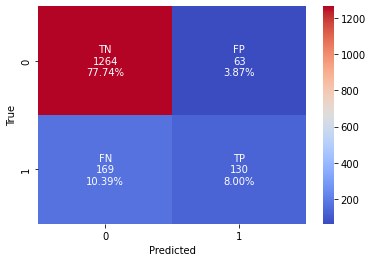

In [76]:
from sklearn.metrics import confusion_matrix

# 오른쪽 위 : 1종 오류 - 실제 틀린데 (0) 맞다고 예측 (1) - 68
# 왼쪽 아래 : 2종 오류 - 실제 맞는데 (1) 틀리다고 예측 (0) - 147
print(confusion_matrix(y_test, test_pred))
cf_matrix = confusion_matrix(y_test, test_pred)
cf_matrix
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()
# TP(양성을 양성으로 판단)
# FN(양성을 음성으로 판단) -> 2종 오류 (맞는데 틀리다고)
# FP(음성을 양성으로 판단) -> 1종 오류 (틀린데 맞다고)
# TN(음성을 음성으로 판단) 

## Classfication Report (분류 리포트)
* 이진분류 할 때 중요 (3개 이상 분류할 때는 상대적으로 덜 중요함)

In [77]:
from sklearn.metrics import classification_report

In [78]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1327
           1       0.67      0.43      0.53       299

    accuracy                           0.86      1626
   macro avg       0.78      0.69      0.72      1626
weighted avg       0.84      0.86      0.84      1626



* 0 : match 성사가 안 된 경우
* **1 : match 성사된 경우** (분석대상이 되는쪽, 예측대상)
* `precision` : 정밀도
* `recall` : 재현율
* `f1-score` : f1-점수

#### 정밀도(precision)
* 1로 예측한 경우 중, 얼마만큼이 실제로 1인지를 나타냄<br>
$TP\over(TP+FP)$
=
$\frac{양성을 양성으로 판단}{양성을 양성으로 판단 + 1종 오류}$
=
$\frac{양성을 양성으로 판단}{양성으로 판단한 수}$
> FP가 커질수록 분모가 커지기 때문에 정밀도는 낮아짐 (1종 오류와 관련)

* 1종 오류 / 위양성 / 아닌데 맞다고 / 안 걸렸는데 걸렸다고 나옴
* 정밀도가 높아지려면 0인데 1로 잘못 분류한게 적어져야함 (FP)

#### 재현율(recall)
* 실제로 1 중에, 얼마만큼을 1로 예측했는지 나타냄<br>
$TP\over(TP+FN)$
=
$\frac{양성을 양성으로 판단}{양성을 양성으로 판단 + 2종 오류}$
=
$\frac{양성을 양성으로 판단}{실제로 양성인 수}$
> FN가 커질수록 분모가 커지기 때문에 재현율은 낮아짐 (2종 오류와 관련)

* 2종 오류 : 맞는데 아니라고 / 걸렸는데 안걸렸다고..
* 재현율이 높아지려고 하면 : 실제로는 1인데 0으로 잡히는 위음성이 줄어들어야함 (FN)

#### F-1점수(f-score)
* 정밀도와 재현율의 조화평균<br>
* 조화평균 : 주어진 수들의 역수의 산술평균의 역수
    * 예) $H = \frac{2a_1a_2}{a_1 + a_2}$

$2 \times \frac{precision \times recall}{precesion + recall}$
=
$2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율}$

> 1종 오류가 중요하면 정밀도, 2종 오류가 중요하면 재현율<br>
> 딱히 중요한 것 없으면 F1-점수

f1 score는 분류 모델의 성능을 평가하는 지표 중 하나로, 정밀도(precision)와 재현율(recall)의 조화평균(harmonic mean)입니다.

정밀도와 재현율은 다음과 같이 정의됩니다.

정밀도 = TP / (TP + FP)

재현율 = TP / (TP + FN)

여기서, TP(True Positive)는 실제로 참인 것을 참으로 분류한 샘플의 수, FP(False Positive)는 실제로 거짓인 것을 참으로 분류한 샘플의 수, FN(False Negative)는 실제로 참인 것을 거짓으로 분류한 샘플의 수를 나타냅니다.

f1 score는 정밀도와 재현율의 조화평균으로 계산됩니다. 조화평균은 평균을 계산하는 방법 중 하나로, 일반적인 산술평균이나 기하평균보다 더욱 작은 값에 민감하게 반응합니다.

따라서 f1 score는 정밀도와 재현율 중에서 작은 값에 민감하게 반응하여, 분류 모델의 성능을 더 정확하게 평가할 수 있습니다. 그리고 이러한 이유로 조화평균을 채택하여 f1 score를 계산합니다.

## 하이퍼 파라미터 튜닝

### 경사하강법
* 머신 러닝이 학습시킬 때 최소의 오차를 찾는 방법
* 오차 함수에 대한 경사도(미분계수)를 기준으로 매개변수를 반복적으로 이동해가며 최소 오차를 찾음
* 매개변수? : 선형 회귀에서의 계수(변수에 대한 기울기 값)에 해당

**경사하강법과 보폭**
* 경사부스팅의 핵심개념 중 하나로, 모델이 어떻게 최소 오차가 되는 매개변수들을 학습하는지에 대한 방법
* 오차식에 대한 미분계수를 통해 매개 변수의 이동 방향과 보폭을 결정
* 보폭은 매개변수를 얼만큼씩 이동할지를 의미

**미분계수**
* 평균변화율에서 x의 증가량을 0으로 가깝게 할 때의 평균변화율
* 그래프 상에서 접선의 기울기, 계수

* learning_rate
    * 경사하강법에서 ‘매개변수’를 얼만큼씩 이동해가면서 최소 오차를 찾을지, 그 보폭의 크기를 결정하는 하이퍼파라미터.
    * 기본적으로 보폭은 미분계수에 의해 결정되지만, learning_rate를 크게 하면 더 큰 보폭을, 작게 하면 그만큼 작은 보폭으로 움직임.
    * learning rate를 우리말로 학습률이라고 함
    * 학습률과 보폭 : 학습률은 입력, 보폭은 그 결과. 큰 학습률을 사용하면 결과적으로 보폭도 커짐
    * 너무 작은 학습률 -> 상당한 시간이 들고, 오버피팅 문제 일어남
    * 너무 큰 학습률 -> 학습이 제대로 안 됨
    * 적절한 크기의 학습률을 사용해야만 큰 시간을 들이지 않고 최소 오차 지점을 찾을 수 있음
* max_depth : 각 트리의 깊이를 제한
* subsample : 모델을 학습시킬 때 일부 데이터만 사용하여 각 트리를 만듦. 0.5를 쓰면 데이터의 절반씩만 랜덤 추출하여 트리를 만듦. 이 또한 오버피팅을 방지하는 데 도움이 됨
* n_estimators : 전체 나무의 개수.

### 그리드 서치
* 하이퍼 패러미터 튜닝
    * 방법 1 : KNN for문으로 가능한 조합을 다 넣어봄 -> 학습 빠르고, 그 때 데이터 자체가 적었고...
    * 방법 2 : 직관, 왠지 잘 되는 수치가 있음
    * 방법 3 : 순정. -> default
    ...
    * 일반적인 몇 가지 수치들을 가지고 조합을 만들어보자
    * grid - 격자 -> 처리

In [79]:
# 학습률 : learning_rate
# max_depth, subsample, nestimators
# dictionary
parameter = {
    'learning_rate': [0.01, 0.1, 0.3], # 학습에 쓰이는 매개변수를 조절해서 최소 오차 허용을 조작 -> 보폭 수정
    'max_depth': [5, 7, 10], # 트리의 깊이 제한 (오버피팅)
    'subsample': [0.5, 0.7, 1], # 학습할 때 데이터 전체 쓰는 게 아니라, subsample 비율에 따라서 부분만 추출
    'n_estimators': [300, 500, 1000] # 트리 개수 3^4 = 81
}
# parameter = {
#     'learning_rate': [0.3],
#     'max_depth': [5],
#     'subsample': [0.5],
#     'n_estimators': [1000]
# }

In [95]:
from sklearn.model_selection import GridSearchCV

In [81]:
model = xgb.XGBClassifier(verbosity=3)

In [82]:
# 모델, 패러미터 dict, n_jobs, scoring='f1', cv=5
# cv = kfold -> folding
# Cross Validation
gs_model = GridSearchCV(
    # n_jobs : CPU 개수 (-1 : 최대로.. colab 2개)
    # scoring : grid별로 모델이 만들어지는 셈 => 모델 간의 비교를? 
    # cv : 얼마나 나눠서 평균치를 구해줄거냐 (Kfold에서의 k)
    model, parameter, n_jobs=-1, scoring='f1', cv=5, verbose=1
)

In [83]:
gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: ignored

In [96]:
gs_model.best_score_ #f1

AttributeError: ignored

In [86]:
gs_model.best_params_

AttributeError: ignored

In [87]:
model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=300,
    max_depth=5,
    subsample=0.5,
    n_jobs=-1,
    random_state=23
)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
# 학습율
print(accuracy_score(y_train, train_pred))
print(accuracy_score(y_test, test_pred))

0.9966174661746617
0.8505535055350554


In [88]:
print(f"accuracy_score : {accuracy_score(y_test, pred)}")
print(classification_report(y_test, pred))

accuracy_score : 0.8554735547355473
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1327
           1       0.69      0.39      0.50       299

    accuracy                           0.86      1626
   macro avg       0.78      0.68      0.71      1626
weighted avg       0.84      0.86      0.84      1626



In [89]:
!pip install mlxtend -q

In [90]:
import joblib

In [91]:
import joblib
from google.colab import files

fn = 'gs_model.pkl'
joblib.dump(gs_model, fn)
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
# Github 서버 -> Colab으로 모델 직접 다운로드 받기
# wget : 리눅스에서 인터넷 다운로드 받을 때 쓰는 명령어
!wget https://github.com/BigData23th/Data/raw/main/gs_model.pkl

--2023-03-23 06:42:36--  https://github.com/BigData23th/Data/raw/main/gs_model.pkl
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BigData23th/Data/main/gs_model.pkl [following]
--2023-03-23 06:42:37--  https://raw.githubusercontent.com/BigData23th/Data/main/gs_model.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 568051 (555K) [application/octet-stream]
Saving to: ‘gs_model.pkl.1’

gs_model.pkl.1      100%[===================>] 554.74K  --.-KB/s    in 0.04s   

2023-03-23 06:42:37 (12.8 MB/s) - ‘gs_model.pkl.1’ saved [568051/568051]



In [93]:
# https://github.com/BigData23th/Data/raw/main/gs_model.pkl
gs_model = joblib.load('gs_model.pkl')
gs_model

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [5, 7, 10],
                         'n_estimators': [300, 500, 1000],
                         'subsample': [0.5, 0.7, 1]},
             scoring='f1', verbose=1)

In [94]:
gs_model.best_params_

AttributeError: ignored

In [97]:
gs_model.best_score_

AttributeError: ignored

In [98]:
from google.colab import files

files.upload()

KeyboardInterrupt: ignored

### 중요 변수 확인

In [99]:
model = xgb.XGBClassifier(learning=0.3, max_depth=5,
                          n_estimators=1000, subsample=0.5, random_state=23)
model.fit(X_train, y_train)

[06:44:09] WARNING: ../src/learner.cc:767: 
Parameters: { "learning" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning=0.3, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [ ]:
# 중요 변수
# xgboost -> feature_importances_
model.feature_importances_

In [ ]:
feature_imp = pd.DataFrame({
    'features': X_train.columns,
    'values': model.feature_importances_,
})

In [ ]:
pd.options.display.float_format = '{:.6f}'.format
feature_imp.head()

In [ ]:
feature_imp.sort_values(by='values', ascending=False)

In [ ]:
plt.figure(figsize=(100, 200))
feature_imp.sort_values(by='values', ascending=True).plot(kind='bar')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False))
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False).head(10))
plt.show()
# 상위 10개의 영향도 높은 변수들